In [1]:
"""
This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017.
Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/.

Code adapted from Stanford CS231N materials: http://cs231n.stanford.edu/
"""


# note to properly run this lab, you should execute all code blocks sequentially
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from collections import namedtuple, defaultdict, deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Introduction to Chainer

Chainer can be understood as Numpy plus the ability to record the computation graph of numerical operations to enable Automatic Differentiation. (Chainer actually also offers many other things; for example, a Numpy equivalent library that runs on GPU, but we will ignore them for now)

Let's illustrate how Chainer works by a simple 1D regression task.

Suppose we have observations from the following model $y = w x + b + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ and the task is to estimate the linear model parameters $w, b$ from data.

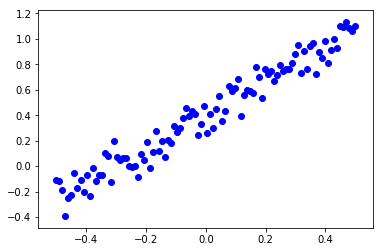

In [2]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32) # Chainer assumes all the cpu computation is done in float32
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

Chainer provides an abstraction called `Link` that describe some computation and keeps track of parameters for it. For instance, a `Linear` link describes a linear map on input and keeps track of `w` and bias `b`.

In [3]:
model = L.Linear(in_size=1, out_size=1) # input is 1D data and output is also 1D data

# Chainer will randomly initialize `w` and `b` for us.
# we can take a look at their values
print("w:", model.W)
print("b:", model.b)

# model.W and model.b have type `chainer.Variable`, 
#   which is a wrapper around Numpy array
assert isinstance(model.W, chainer.Variable)

# operations that involve `chainer.Variable` will produce
#   `chainer.Variable` and this records the computation graph
var_result = model.W + 123 # some random computation
print("Operations on chainer.Variable: %s, type: %s" % (var_result, type(var_result)))

# the underlying numpy array can be accessed by `data` attribute
print("numpy arrays:", model.W.data, var_result.data)

w: variable W([[-0.85361528]])
b: variable b([ 0.])
Operations on chainer.Variable: variable([[ 122.14638519]]), type: <class 'chainer.variable.Variable'>
numpy arrays: [[-0.85361528]] [[ 122.14638519]]


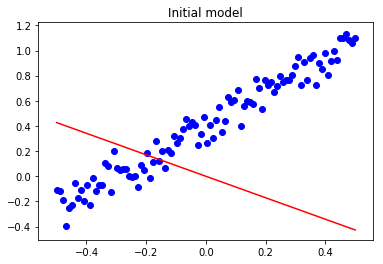

In [4]:
# A chainer link is a callable object. calling it performs the
#   forward computation. (in this case, it performs Wx + b)
model_y = model(data_x[:, None]) # chainer's link usually assumes input is [Batch Size, Input Dimension]
# `model_y` is a chainer variable so we use `.data` to access its numpy array for plotting

# we can plot the model's current fit in red. it should be terrible because we haven't trained it yet
_ = plt.plot(data_x, model_y.data[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [5]:
# now let's walk through how to perform forward computation
#  and use AD to get gradients

# first we clear the gradients that are stored in the model
model.cleargrads()
# as we have seen we can perform forward computation by calling the link
model_y = model(data_x[:, None])

# remember that `model_y` is a chainer variable. to operate on chainer variable
#    we will use functions from chainer.functions to operate on those objects.
loss = F.mean(F.square(model_y - data_y[:, None]))
# `loss` is a scalar chainer variable
assert isinstance(loss, chainer.Variable)
print("loss", loss)
# calculating gradients d loss /d params is as simple as
loss.backward()

# we can inspect the gradient of loss with respect to W
print("dloss/dW", model.W.grad)

loss variable(0.5818337202072144)
dloss/dW [[-0.37226769]]


Now that we know how to calculate gradients, we can code up a simple loop to perform gradient descent to train this model:

(Hint: if you run into weird problems, maybe the state has been messed up and you can try re-runing all the code blocks from the beginning)

Itr 0 loss: variable(0.5772851705551147)
Itr 25 loss: variable(0.07919134944677353)
Itr 50 loss: variable(0.020412852987647057)
Itr 75 loss: variable(0.009991518221795559)


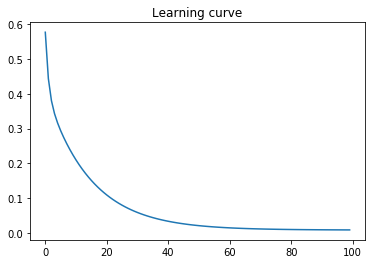

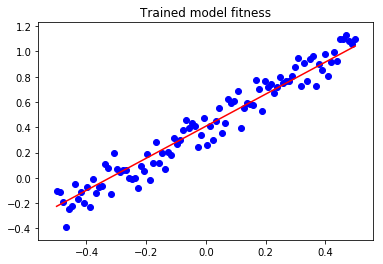

In [6]:
# now we can perform gradient descent to improve this model
model = L.Linear(in_size=1, out_size=1)
alpha = 0.2
losses = []

for i in range(100):
    model.cleargrads()
    loss = F.mean(F.square(model(data_x[:, None]) - data_y[:, None]))
    losses.append(float(loss.data))
    # *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    # Hint: you could access gradients with model.W.grad, model.b.grad
    # Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    # Hint3: if your model doesn't learn, remember to try different learning rates
    
    # My Code -------------------------------------------------------------------------
    loss.backward()
    model.W.data = model.W.data - alpha*model.W.grad
    model.b.data = model.b.data - alpha*model.b.grad
    #----------------------------------------------------------------------------------
    
    if i % 25 == 0:
        print("Itr", i, "loss:", loss)
plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x[:, None])[:,0].data, c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")


## Train your first deep model

Now we have learned the basics of Chainer. We can use it to train a deep model to classify MNIST digits. We will train a model on the MNIST dataset because the dataset is small.

First we load the data and see what the images look like:

train[i][0] is the ith image that's flattened, and has shape: (784,)
train[i][1] is the ith image's label, such as: 3


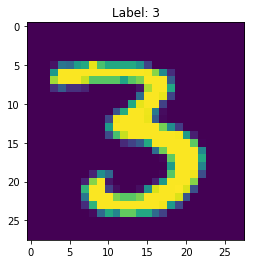

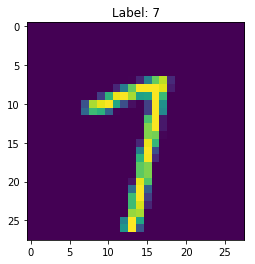

In [7]:
train, test = chainer.datasets.get_mnist()
# use train[data_point_index] to access data
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])
# here we visualize two of them
plt.imshow(train[12][0].reshape([28, 28,]))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].reshape([28, 28,]))
_ = plt.title("Label: %s" % train[42][1])

Next we will provide some boilerplate code and train a linear classifier as an example:

In [8]:
def run(model, batchsize=16, num_epochs=2):
    
    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

# try a simple linear model
run(L.Linear(None, 10))

accuracy: 0.0; loss: 2.34252309799
accuracy: 0.855; loss: 0.583878424168
accuracy: 0.8625; loss: 0.536365298033
accuracy: 0.895; loss: 0.385457939506
accuracy: 0.89; loss: 0.409021454453
accuracy: 0.8925; loss: 0.357999569178
accuracy: 0.9125; loss: 0.354019462168
accuracy: 0.8975; loss: 0.328560582995
accuracy: 0.9075; loss: 0.31921361208
accuracy: 0.91; loss: 0.284260829985
accuracy: 0.91; loss: 0.318108589053
accuracy: 0.9225; loss: 0.350044072866
accuracy: 0.9125; loss: 0.32112103343
accuracy: 0.8925; loss: 0.341223171651
accuracy: 0.9325; loss: 0.324537373483
accuracy: 0.93; loss: 0.233627987951
accuracy: 0.915; loss: 0.268622439206
accuracy: 0.91; loss: 0.327529040575
accuracy: 0.92; loss: 0.271666261554
accuracy: 0.92; loss: 0.238883302212
accuracy: 0.925; loss: 0.296549168974
accuracy: 0.8975; loss: 0.360791115165
accuracy: 0.91; loss: 0.291468892992
accuracy: 0.925; loss: 0.270953889191
accuracy: 0.9175; loss: 0.348180883527
accuracy: 0.9125; loss: 0.281553665698


Next we will try to improve performance by training an MLP instead. A partial implementation is provided for you to fill in:

In [10]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        
        # My Code --------------------------------------------------------------------------------
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        
        return x
        #-----------------------------------------------------------------------------------------
        
        #raise NotImplementedError()
        
run(MLP(200, 10))

accuracy: 0.125; loss: 2.33366680145
accuracy: 0.925; loss: 0.327287918925
accuracy: 0.9125; loss: 0.269574716389
accuracy: 0.9425; loss: 0.162295832932
accuracy: 0.9325; loss: 0.196674365401
accuracy: 0.92; loss: 0.29744461596
accuracy: 0.9325; loss: 0.206816905439
accuracy: 0.945; loss: 0.159774872661
accuracy: 0.9475; loss: 0.138599238992
accuracy: 0.955; loss: 0.0983626687527
accuracy: 0.9525; loss: 0.145664195418
accuracy: 0.945; loss: 0.165778856277
accuracy: 0.9675; loss: 0.0930352607369
accuracy: 0.9625; loss: 0.131526424289
accuracy: 0.9725; loss: 0.0966155105829
accuracy: 0.97; loss: 0.0927044895291
accuracy: 0.9625; loss: 0.119628617167
accuracy: 0.9725; loss: 0.125942375958
accuracy: 0.9625; loss: 0.113571524024
accuracy: 0.9725; loss: 0.0984774821997
accuracy: 0.9825; loss: 0.0692796391249
accuracy: 0.965; loss: 0.107271764576
accuracy: 0.975; loss: 0.0898927253485
accuracy: 0.975; loss: 0.0995692932606
accuracy: 0.9825; loss: 0.0574143785238
accuracy: 0.9875; loss: 0.0436

Next you should try to implement logging test loss and see if the model is overfitting.

In [11]:
def better_run(model, batchsize=16, num_epochs=2):

    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # *** YOUR CODE implement logging of stats on test set ***
                
                # My Code ---------------------------------------------------------------------
                xs = np.concatenate([datum[0][None, :] for datum in test])
                ys = np.array([datum[1] for datum in test])
                logits = model(xs)
                stats["test_accuracy"] = F.accuracy(logits, ys).data
                stats["test_loss"] = F.softmax_cross_entropy(logits, ys).data
                #------------------------------------------------------------------------------
                
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

better_run(MLP(200, 10))

accuracy: 0.125; loss: 2.23146915436; test_loss: 2.30454; test_accuracy: 0.1452
accuracy: 0.8975; loss: 0.356777539253; test_loss: 0.27408; test_accuracy: 0.9194
accuracy: 0.9375; loss: 0.213662660718; test_loss: 0.246645; test_accuracy: 0.9275
accuracy: 0.915; loss: 0.296771633625; test_loss: 0.236843; test_accuracy: 0.9252
accuracy: 0.925; loss: 0.230236728787; test_loss: 0.189781; test_accuracy: 0.9425
accuracy: 0.9375; loss: 0.202376939058; test_loss: 0.168635; test_accuracy: 0.9459
accuracy: 0.9575; loss: 0.11509108603; test_loss: 0.133319; test_accuracy: 0.9586
accuracy: 0.9675; loss: 0.116689117551; test_loss: 0.15093; test_accuracy: 0.9529
accuracy: 0.975; loss: 0.0941457682848; test_loss: 0.124514; test_accuracy: 0.9596
accuracy: 0.955; loss: 0.149147657156; test_loss: 0.119764; test_accuracy: 0.963
accuracy: 0.965; loss: 0.130908405185; test_loss: 0.105502; test_accuracy: 0.9668
accuracy: 0.96; loss: 0.100071471035; test_loss: 0.111564; test_accuracy: 0.9647
accuracy: 0.9475;

Try different variants!

- Does using a ConvNet improve performance (reduce overfitting?)
- Try changing the learning rate and observe the effect
- Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc